In [25]:
import os
import glob
import pandas as pd
import lpips
import math
import plotly.express as px
import numpy as np
from natsort import natsorted
import cv2
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score
import scipy.stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from openpyxl import Workbook
from openpyxl.drawing.image import Image as Image_openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.drawing.xdr import XDRPositiveSize2D
from openpyxl.utils.units import pixels_to_EMU, cm_to_EMU
from openpyxl.drawing.spreadsheet_drawing import OneCellAnchor, AnchorMarker
import pickle
from scipy.sparse.linalg import lsqr

In [26]:
loss_fn_alex = lpips.LPIPS(net='alex')
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.



Loading model from: /Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.



Loading model from: /Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/venv/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [27]:
images_dir = '/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/Images'
data_path = '/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data'
gt_fol = os.path.join(data_path, "GT_N")

In [49]:
def get_mAP(targets, preds):
    APs = np.zeros(preds.shape[1])
    APs2 = np.zeros(preds.shape[1])
    ARs = np.zeros(preds.shape[1])
    F1s = np.zeros(preds.shape[1])
    ACCs = np.zeros(preds.shape[1])
    for k in range(preds.shape[1]):
        APs[k], ARs[k], F1s[k], ACCs[k] = _average_precision_2(targets[:, k], preds[:, k])
        APs2[k] = _average_precision(targets[:, k], preds[:, k])

    return APs, ARs, F1s, ACCs, APs2

def _average_precision(output, target):
    # print(output, target)
    epsilon = 1e-8

    # sort examples
    indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    target_ = target[indices]

    ind = target_ == 1

    pos_count_ = np.cumsum(ind)

    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0

    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    # print(pp, precision_at_i_, pos_count_, total_count_)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i


def _average_precision_2(target, output):
    epsilon = 1e-8

    total_pred_pos = np.count_nonzero(output)
    total_target_pos = np.count_nonzero(target)

    TP = np.count_nonzero(np.logical_and(output, target))
    TN = np.count_nonzero(np.logical_and(np.logical_not(output), np.logical_not(target)))
    FP = total_pred_pos - TP
    FN = total_target_pos - TP

    AP = TP / (TP + FP + epsilon)
    AR = TP / (TP + FN + epsilon)
    F1 = (2 * AP * AR) / (AP + AR + epsilon)
    ACC = (TP + FP) / (TP + TN + FP + FN + epsilon)

    return AP, AR, F1, ACC


def calculate_model_map(gt_path, gt_files, pred_path, obj_list=None):
    gt_dict = {}
    pred_dict = {}

    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        gt_data.replace(-1, 1, inplace=True)
        x = []
        for index, row in gt_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in gt_dict.keys():
                gt_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                gt_dict[list(row)[0].strip().lower()] = list(row)[1:]

            x.append(len(list(row)[1:]))

        y = []
        pred_data = pd.read_csv(pred_fl)
        pred_data.replace(-1, 1, inplace=True)
        for index, row in pred_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in pred_dict.keys():
                pred_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                pred_dict[list(row)[0].strip().lower()] = list(row)[1:]
            y.append(len(list(row)[1:]))

        if x != y:
            print(len(x), len(y), fl)

    target_array = []
    pred_array = []

    label_names = []

    for key in gt_dict.keys():
        if key in pred_dict.keys():
            if obj_list:
                if key not in obj_list:
                    continue
            if len(gt_dict[key]) == len(pred_dict[key]):
                target_array.append(gt_dict[key])
                pred_array.append(pred_dict[key])
                label_names.append(key)
            else:
                print(len(gt_dict[key]), len(pred_dict[key]), key)
    
    target_array = np.array(target_array).T
    pred_array = np.array(pred_array).T

    try:
        precs = precision_score(target_array, pred_array, average="binary")
    except Exception as e:
        # ap = 0
        print(e)
        precs = 0.0

    return precs

In [50]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_f = transforms.ToTensor()

def normalize_image(in_img):
    pixels = np.asarray(in_img).astype('float32')
    pixels = (pixels - mean) / std
    return pixels

In [40]:
def get_steady_state_probabilities_ifs(pred, img_dir, vid_n, seg_n, sim_dict):
    pred = pred.T
    # unq_st = np.unique(pred, axis=0)
    unq_st = []
    for p_ in pred:
        pppp = list(p_)
        if pppp not in unq_st:
            unq_st.append(pppp)

    unq_st = np.array(unq_st)
            
    unq_st_str = []
    # for x in unq_st:
    #     str_bit = [str(ch) for ch in x]
    #     unq_st_str.append(''.join(str_bit))

    # print(unq_st[0].shape[0])
    n_o_f = 2**(unq_st[0].shape[0])
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(unq_st[0].shape[0])
        unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    d_s = [0.0]

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        # if f == 1:
        #     init_state = ''.join([str(ch) for ch in pred[f-1]])
        # s_prev = ''.join([str(ch) for ch in pred[f-1]])
        # f_now_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f}.jpeg')
        # f_prev_pth = os.path.join(img_dir, f'video-{vid_n}-segment-{seg_n}-frame-{f-1}.jpeg')

        # image_now = cv2.resize(normalize_image(np.array(Image.open(
        #     f_now_pth
        # ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        # image_prev = cv2.resize(normalize_image(np.array(Image.open(
        #     f_prev_pth
        # ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        # img0 = transform_f(image_now).unsqueeze(0)
        # img1 = transform_f(image_prev).unsqueeze(0)

        # if f == 1:
        #     transition_matrix[s_prev][s_prev] = 1

        # if s_prev == s_now:
        #     transition_matrix[s_prev][s_prev] = 1
        # else:
        #     d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
        #     transition_matrix[s_prev][s_prev] += (1.0*d)
        #     transition_matrix[s_now][s_prev] += (1.0*(1-d))
        #     if d < 0.5:
        #         init_state = ''.join([str(ch) for ch in pred[f]])

        d = sim_dict[f'video-{vid_n}-segment-{seg_n}'][f'{f-1}-{f}'] # loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]
        d_s.append(d)
        # print(d, os.path.basename(f_now_pth), os.path.basename(f_prev_pth))

        # if s_now == s_prev:
        #     transition_matrix[init_state][init_state] += (1.0*d)
        #     transition_matrix[init_state][init_state] += (1.0*(1-d))
        # else:
        #     transition_matrix[s_now][init_state] += (1.0*(1-d))
        #     transition_matrix[init_state][init_state] += (1.0*d)
            
        #     if d < 0.5:
        #         init_state = ''.join([str(ch) for ch in pred[f]])

        # transition_matrix[s_prev][s_prev] += (1.0*d)
        d_frac = d/((2**n_o_f)-1)
        transition_matrix[s_now][s_prev] += (1.0*(1-d))
        for s_c in transition_matrix.index:
            if s_c not in [s_now]:
                transition_matrix[s_c][s_prev] += d_frac
                # transition_matrix[s_prev][s_c] += d_frac

        # if d < 0.5:
        #     init_state = ''.join([str(ch) for ch in pred[f]])

        
        # print(d, s_prev, s_now)

    # p_s_ifs = list(transition_matrix.sum())
    transition_matrix = np.array(transition_matrix)

    # print(transition_matrix)

    N_t_s = transition_matrix.sum(axis=1)
    alpha = 1e-3
    d_ps = N_t_s.shape[0]
    
    # tmx_shape = transition_matrix.shape
    # transition_matrix = transition_matrix.reshape((tmx_shape[0] * tmx_shape[1]))
    # N_t = transition_matrix.sum()
    # alpha = 1e-3
    # d = transition_matrix.shape[0]
    # transition_matrix = (transition_matrix + alpha) * (N_t / (N_t + (alpha * d)))
    # transition_matrix = transition_matrix / np.sum(transition_matrix)
    # transition_matrix = transition_matrix.reshape(tmx_shape)
    
    for ind, row in enumerate(transition_matrix):
        new_row = (row + alpha) * (N_t_s[ind] / (N_t_s[ind] + (alpha * d_ps)))
        new_row = new_row / (np.sum(new_row) + 1e-20)
        transition_matrix[ind] = new_row
        
        # transition_matrix.loc[ind] = row
    # p_s_ifs = [ccc/sum(p_s_ifs) for ccc in p_s_ifs]

    I = np.identity(transition_matrix.shape[0])
    P_I = transition_matrix - I
    co_eff = P_I.T

    # co_eff[co_eff.shape[0]-1] =  np.ones((co_eff.shape[1]))
    # const = np.array([0.0 for _ in range(co_eff.shape[0])])
    # const[const.shape[0]-1] = 1.0
    # co_eff[0] =  np.ones((co_eff.shape[1]))
    # const = np.array([0.0 for _ in range(co_eff.shape[0])])
    # const[0] = 1.0

    const = np.array([0.0 for _ in range(co_eff.shape[0])])
    co_eff =  np.append(np.ones((1, co_eff.shape[1])), co_eff, axis=0)
    const = np.append(np.array([1]), const)
    

    try:
        p_s_ifs = lsqr(co_eff, const)[0] # np.linalg.solve(co_eff, const)
    except:
        print(det(co_eff), vid_n, seg_n)
        p_s_ifs = lsqr(co_eff, const)[0] # np.linalg.solve(co_eff, const)

    p_s_ifs = list(p_s_ifs)
    # print(p_s_ifs)
    for s_ind in range((2**(unq_st[0].shape[0]))-len(p_s_ifs)):
        p_s_ifs.append(0.0)

    p_s_ifs = np.array(p_s_ifs)
    
    return p_s_ifs, d_s

In [41]:
def get_steady_state_probabilities(h_m):
    hm = np.array(h_m).T
    unique_states = np.unique(hm, axis=0)
    unq_st_and_count = {}
    for i, u_s in enumerate(unique_states):
        c = np.argwhere(np.all(hm == u_s, axis=-1)).shape[0]
        unq_st_and_count[i] = {
            'val': u_s,
            'count': c,
            'ss_prob': c/hm.shape[0]
        }

    return np.array([unq_st_and_count[k]['ss_prob'] for k in unq_st_and_count.keys()])


def calculate_entropy(ss_probs):
    if len(ss_probs) <= 1:
        return 0.0

    tot_ss_ent = 0

    for prb in ss_probs:
        if prb == 0:
            log_p_ss = 0
        else:
            try:
                log_p_ss = math.log2(prb)
            except:
                log_p_ss = 0.0 # math.log2(prb+1e-15)

        t_ent = - prb * log_p_ss

        tot_ss_ent = tot_ss_ent + t_ent

    tot_ss_ent = tot_ss_ent / math.log2(len(ss_probs))

    return tot_ss_ent

In [42]:
def get_st_p_ent(vid, seg, img_path, objs, model, sim_dict):
    pred_file = os.path.join(
        data_path,
        f'{model}/video-{vid}-segment-{seg}.csv'
    )
    pred_df = pd.read_csv(pred_file)
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()

    p_steady_ifs, d_s = get_steady_state_probabilities_ifs(np.array(pred_df), images_dir, vid, seg, sim_dict)
    ent_ifs = calculate_entropy(p_steady_ifs)

    p_steady = get_steady_state_probabilities(np.array(pred_df))
    ent = calculate_entropy(p_steady)

    return p_steady, ent, p_steady_ifs, ent_ifs, d_s

In [43]:
def gen_heat_map(gt_path, gt_files, pred_path, obj_list=None, d_s=[]):
    hm_figs = []
    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        gt_data.replace(-1, 1, inplace=True)

        gt_data = gt_data.transpose()
        gt_data.columns = gt_data.iloc[0]
        gt_data = gt_data.iloc[1:]
        gt_data.columns = gt_data.columns.str.lower()
        if obj_list is not None:
            gt_data = gt_data.reindex(columns=obj_list)
    
        gt_data = gt_data.fillna('0').transpose()
        gt_data.columns = gt_data.columns.str.replace("_", "-")
        gt_data.columns = gt_data.columns.str.capitalize()

        pred_data = pd.read_csv(pred_fl)
        pred_data.replace(-1, 1, inplace=True)

        pred_data = pred_data.transpose()
        pred_data.columns = pred_data.iloc[0]
        pred_data = pred_data.iloc[1:]
        pred_data.columns = pred_data.columns.str.lower()
        if obj_list is not None:
            pred_data = pred_data.reindex(columns=obj_list)
    
        pred_data = pred_data.fillna('0').transpose()
        pred_data.columns = pred_data.columns.str.replace("_", "-")
        pred_data.columns = pred_data.columns.str.capitalize()

        hm_ = gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

        color_tp = 'rgb(71, 137, 209)' 
        color_tn = 'rgb(104, 212, 202)'
        color_fp = 'rgb(202, 121, 59)' 
        color_fn = 'rgb(198, 59, 59)'
        
        fig = go.Figure()
        
        colorscale = [
            [0, color_fp],
            [0.25, color_tn],
            [0.5, color_tp],
            [1, color_fn]
        ]
        
        fig.update_layout(
            template="simple_white",
            xaxis=dict(title_text="Frames", tickmode='linear'),
            yaxis=dict(title_text="Objects",  tickmode='linear'),
            width=1000,
            height=250,
            margin=dict(l=0, r=0, t=10, b=5),
            title=dict(
                text="",
                font=dict(size=16, color="black"),
                x=0.5,
                y=0.995
        
            )
        )
        
        fig.add_trace(
            go.Heatmap(
                z=hm_,
                x=[f'{i} {d_s[i]:.2f}' for i, x in enumerate(list(hm_.columns))],
                y=[x.capitalize() for i, x in enumerate(list(hm_.index))],
                colorscale=colorscale,
                zmin=-1,
                zmax=2
            )
        )


        # fig.add_traces(go.Bar(x=[], y =[], name='TP',
        #                  marker_color=color_tp))
        # fig.add_traces(go.Bar(x=[], y =[], name='FP',
        #                  marker_color=color_fp))
        # fig.add_traces(go.Bar(x=[], y =[], name='TN',
        #                  marker_color=color_tn))
        # fig.add_traces(go.Bar(x=[], y =[], name='FN',
        #                  marker_color=color_fn))
        
        fig.update_layout(
            font_family="Courier New, monospace",
            font_color="black",
            title_font_family="Courier New, monospace",
            title_font_color="black",
            legend_title_font_color="black",
            font=dict(size=14),
        )

        fig.update_traces(
          colorbar_tickmode='array',
          colorbar_ticktext=['FP', 'TN', 'TP', 'FN'],
          colorbar_tickvals=[-1, 0, 1, 2],
          colorbar_tickangle=0,
          selector=dict(type='heatmap')
         )

        fig.update_xaxes(ticklabelposition='outside')
        
        fig.update_xaxes(
            tickson="boundaries",
            ticklen=5,
            tickangle=90
        )
        fig.update_layout(
             xaxis=dict(showgrid=True),
             yaxis=dict(showgrid=True)
        )
        
        fig.update_layout(xaxis=dict(domain=[0, 1]))
        
        hm_figs.append(fig)
    

    return hm_figs

In [44]:
coco_common_obj = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'traffic signals', 'fire hydrant', 'stop sign',
                   'bench', 'dog', 'chair', 'vegetation']

pfb_common_obj = ['road', 'sidewalk', 'tree', 'vegetation', 'building', 'fence', 'traffic signals',
                  'fire hydrant', 'chair', 'trash on roads', 'trash bins', 'person', 'car', 'motorcycle',
                  'bus']

ram_obj_map = {
    'chair': 'chair',
    'pillar': 'pillar',
    'table': 'table',
    'person': 'person',
    'man': 'person',
    'building': 'building',
    'city street': 'road',
    'curb': 'curb',
    'pavement': 'sidewalk',
    'road': 'road',
    'car': 'car',
    'snow': 'snow',
    'doorway': 'sloped driveway',
    'elevator': 'elevator',
    'rail': 'train tracks',
    'stair': 'stairs',
    'cane': 'white cane',
    'door': 'flush door',
    'fence': 'fence',
    'barrier': 'barrier post',
    'bench': 'bench',
    'sign': 'sign',
    'bin': 'trash bins',
    'pole': 'pole',
    'street vendor': 'street vendor',
    'blind': 'person with a disability',
    'dog': 'dog',
    'escalator': 'escalator',
    'street sign': 'sign post',
    'bus stop': 'bus stop',
    'railway station': 'train platform',
    'tree': 'tree',
    'traffic light': 'traffic signals',
    'tree trunk': 'tree',
    'recycling bin': 'trash bins',
    'train track': 'train tracks',
    'pedestrian': 'person',
    'bus': 'bus',
    'city bus': 'bus',
    'tour bus': 'bus',
    'wall': 'wall',
    'elevator door': 'elevator',
    'bicycle': 'bicycle',
    'crosswalk': 'crosswalk',
    'decker bus': 'bus',
    'motorcycle': 'motorcycle',
    'motorcyclist': 'person',
    'biker': 'person',
    'motorbike': 'motorcycle',
    'warning sign': 'sign',
    'hydrant': 'fire hydrant',
    'school bus': 'bus',
    'vegetation': 'vegetation',
    'fountain': 'fountain'
}

ram_com_obj = list(set(list(ram_obj_map.values())))

print(len(ram_com_obj))

39


In [45]:
gt_dir = gt_fol # "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GT_N"

gts = natsorted(os.listdir(gt_dir))

skip_list = [
    "video-10-segment-1.csv", "video-9-segment-2.csv"
]

gts = [x.split('.')[0] for x in gts if x.endswith('.csv') and int(x.split('-')[1])<=16 and x not in skip_list]

# gts = ['video-1-segment-4']

len(gts)

19

In [46]:
all_com = natsorted(list(set(ram_com_obj) & set(coco_common_obj) & set(pfb_common_obj)))
all_com

['bus',
 'car',
 'chair',
 'fire hydrant',
 'motorcycle',
 'person',
 'traffic signals',
 'vegetation']

In [47]:
models = {
    'GT_N': 'all_com',
    'BLIP': 'all_com',
    'GPV-1': 'all_com',
    'RAM': 'all_com',
    'yolo_v7': 'all_com',
    'HRNet_V2': 'all_com',
    'mask_rcnn': 'all_com',
    'faster_rcnn': 'all_com'
}
# models = {
#     'GPV-1': 'all_com',
# }

models = {
    'GT_N': 'all_com',
    'BLIP': 'all_com',
    'GPV-1': 'all_com',
    'RAM': 'all_com',
    'yolo_v7': 'all_com',
    'mask_rcnn': 'all_com',
    'faster_rcnn': 'all_com'
}

In [48]:
vid_wise_ent = {
    'Models': gts
}

vid_wise_prec = {
    'Models': gts
}
out_plot_path = './heat_maps'

workbook = Workbook()
worksheet = workbook.active

row = 2

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

for mod_ind, model_ in enumerate(models.keys()):
    ents_all_vid = []
    ents_all_vid_normal = []
    ps_all_vid = []
    col = 2
    worksheet.row_dimensions[row].height = 195
    worksheet.cell(row=row, column=1).value = model_
    worksheet.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

    for gt in gts:    
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])
        
        if mod_ind == 0:
            worksheet.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
            worksheet.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
            
        p_s, e_, p_s_i, e_i, d_i_s = get_st_p_ent(v_, s_, images_dir, eval(models[model_]), model_, sim_dict_pkl)

        ents_all_vid.append(e_i)
        ents_all_vid_normal.append(e_)
        # print(e_i, p_s_i)

        pred_fol = os.path.join(data_path, model_)
        p_ = calculate_model_map(
            gt_fol, [f'{gt}.csv'], pred_fol, 
            obj_list=eval(models[model_])
        )
        ps_all_vid.append(p_)
        hm_p = gen_heat_map(
            gt_fol, [f'{gt}.csv'], pred_fol, 
            obj_list=eval(models[model_]), d_s=d_i_s
        )[0]
        hm_p.update_layout(
            title=dict(text=f"mAP={p_:.2f}, mENT={e_i:.2f}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_out_name = os.path.join(out_plot_path, f'{model_}_v{v_}s{s_}_mAP_{p_:.2f}_mENT_{e_i:.2f}.png')

        hm_p.write_image(
            img_out_name,
            format='png'
        )

        worksheet.column_dimensions[get_column_letter(col)].width = 128

        anchor = f'{get_column_letter(col)}{row}'
        # worksheet.add_image(Image_openpyxl(img_out_name), anchor=anchor)
        img = Image_openpyxl(img_out_name) 

        worksheet.add_image(img, anchor=anchor)
    
        col = col + 1
        
    if model_ == 'GT_N':
        vid_wise_ent[f"{model_} (with lpips)"] = ents_all_vid
        vid_wise_ent[f"{model_} (without lpips)"] = ents_all_vid_normal
    else:
        vid_wise_ent[model_] = ents_all_vid
         
    vid_wise_prec[model_] = ps_all_vid
    row = row + 1

workbook.save('investigate_entropy.xlsx')

In [24]:
vid_wise_model_ent_df = pd.DataFrame(vid_wise_ent).transpose()
vid_wise_model_ent_df.columns = vid_wise_model_ent_df.iloc[0]
vid_wise_model_ent_df = vid_wise_model_ent_df.iloc[1:]

In [67]:
ssdf = pd.DataFrame(vid_wise_ent) # .sort_values(by=['GT_N (with lpips)'])
for col in list(ssdf.columns)[1:]:
    ssdf[col] = ssdf[col].round(2)
# ssdf['GT_N (without lpips)'] = ssdf['GT_N (without lpips)'].round(2)
ssdf = ssdf.transpose()
ssdf.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in ssdf.iloc[0]]
ssdf = ssdf.iloc[1:]

In [68]:
ssdf

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
GT_N (with lpips),0.12,0.02,0.21,0.06,0.02,0.26,0.01,0.18,0.05,0.04,0.23,0.0,0.02,0.03,0.12,0.03,0.0,0.0,0.09
GT_N (without lpips),1.0,0.89,0.83,0.41,0.82,0.94,0.99,0.56,0.4,0.3,0.95,0.0,0.79,0.89,0.76,0.57,0.52,0.0,0.52
BLIP,0.15,0.02,0.38,0.02,0.3,0.34,0.36,0.28,0.07,0.16,0.33,0.13,0.03,0.09,0.06,0.04,0.34,0.09,0.09
GPV-1,0.13,0.36,0.42,0.18,0.34,0.4,0.28,0.22,0.29,0.31,0.39,0.34,0.22,0.12,0.19,0.31,0.24,0.08,0.16
RAM,0.0,0.17,0.01,0.11,0.11,0.21,0.06,0.07,0.05,0.06,0.2,0.04,0.09,0.13,0.08,0.0,0.12,0.07,0.0
yolo_v7,0.1,0.2,0.18,0.0,0.12,0.24,0.1,0.06,0.03,0.04,0.12,0.09,0.18,0.02,0.03,0.07,0.1,0.01,0.06
mask_rcnn,0.16,0.41,0.45,0.3,0.19,0.31,0.34,0.36,0.22,0.16,0.16,0.38,0.32,0.11,0.13,0.03,0.37,0.27,0.28
faster_rcnn,0.35,0.34,0.37,0.26,0.36,0.32,0.34,0.33,0.22,0.13,0.43,0.34,0.33,0.18,0.3,0.04,0.35,0.32,0.21


In [69]:
vid_wise_model_prec_df = pd.DataFrame(vid_wise_prec).transpose()
vid_wise_model_prec_df.columns = vid_wise_model_prec_df.iloc[0]
vid_wise_model_prec_df = vid_wise_model_prec_df.iloc[1:]

In [70]:
vid_wise_model_prec_df

Models,video-1-segment-4,video-1-segment-5,video-2-segment-1,video-3-segment-2,video-3-segment-3,video-4-segment-1,video-4-segment-3,video-4-segment-4,video-5-segment-1,video-6-segment-2,video-7-segment-2,video-8-segment-2,video-11-segment-1,video-12-segment-4,video-13-segment-2,video-14-segment-1,video-14-segment-4,video-15-segment-3,video-16-segment-3
GT_N,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BLIP,0.857143,0.875,0.723881,0.705882,0.870968,0.846154,0.57971,0.8,0.766667,0.588235,0.789474,0.564516,0.849057,0.913043,0.890244,0.816327,0.652174,0.9375,0.676471
GPV-1,0.920635,0.625,0.839286,0.827586,0.729927,0.657895,0.818182,0.705263,0.396552,0.588235,0.763158,0.522388,0.612903,0.890625,0.925,0.784314,0.689655,0.795918,0.971429
RAM,1.0,0.954545,1.0,1.0,1.0,1.0,1.0,0.967213,0.956522,1.0,1.0,0.945946,0.956522,1.0,0.925,1.0,1.0,1.0,1.0
yolo_v7,1.0,0.8,0.916667,1.0,1.0,1.0,1.0,0.958904,0.958333,1.0,0.958333,0.918919,0.880952,1.0,0.945946,1.0,0.916667,0.944444,1.0
mask_rcnn,0.777778,0.416667,0.677632,0.638889,0.569832,0.658537,0.76,0.606061,0.657143,0.7,0.658537,0.376344,0.513158,0.866667,0.8,0.682927,0.535714,0.784314,0.825
faster_rcnn,0.724138,0.488372,0.660377,0.75,0.618182,0.7,0.804348,0.621212,0.638889,0.8,0.666667,0.406977,0.541667,0.753623,0.744898,0.651163,0.466667,0.788462,0.755556


In [494]:
mEnt = {}

for key in dict(vid_wise_model_ent_df.mean(axis='columns')):
    if key in ['HRNet_V2', 'GT_N (without lpips)']: # , 'GT_N (with lpips)'
        continue
    mEnt[key] = dict(vid_wise_model_ent_df.mean(axis='columns'))[key]

mEnt

{'GT_N (with lpips)': 0.051663781532568766,
 'BLIP': 0.14159848986931098,
 'GPV-1': 0.22291720568408296,
 'RAM': 0.07146169355230973,
 'yolo_v7': 0.08006730172233383,
 'mask_rcnn': 0.24048429600523616,
 'faster_rcnn': 0.25397381019256615}

In [495]:
mAP = {
    'GT_N (with lpips)': 1.0,
    'BLIP': 0.79,
    'GPV-1': 0.75,
    'RAM': 0.98,
    'yolo_v7': 0.96,
    'mask_rcnn': 0.64,
    'faster_rcnn': 0.65
}

#     'HRNet_V2': 0.59,

mF1 = {
    'BLIP': 0.28,
    'GPV-1': 0.23,
    'RAM': 0.24,
    'yolo_v7': 0.54,
    'mask_rcnn': 0.41,
    'faster_rcnn': 0.42
}

#    'HRNet_V2': 0.36,

pearson:  PearsonRResult(statistic=-0.977493314759631, pvalue=0.00014420360580373682)
spearman:  SignificanceResult(statistic=-0.9642857142857145, pvalue=0.0004541491691941689)
kendall:  SignificanceResult(statistic=-0.9047619047619049, pvalue=0.002777777777777778)


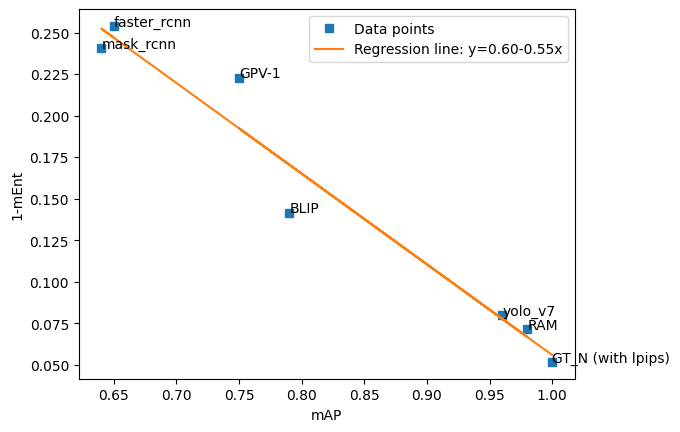

In [496]:
x, y = np.array(list(mAP.values())), np.array(list(mEnt.values()))
print("pearson: ", scipy.stats.pearsonr(x, y))
print("spearman: ", scipy.stats.spearmanr(x, y))
print("kendall: ", scipy.stats.kendalltau(x, y))
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}-{abs(slope):.2f}x'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
for i, txt in enumerate(mAP.keys()):
    ax.annotate(txt, (x[i], y[i]))
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('mAP')
ax.set_ylabel('1-mEnt')
ax.legend(facecolor='white')
# plt.xlim(0.18, 0.7)
# plt.ylim(0.36, 0.55)
plt.show()

pearson:  PearsonRResult(statistic=0.046031022482007196, pvalue=0.931002232808767)
spearman:  SignificanceResult(statistic=0.2, pvalue=0.704)
kendall:  SignificanceResult(statistic=0.2, pvalue=0.7194444444444444)


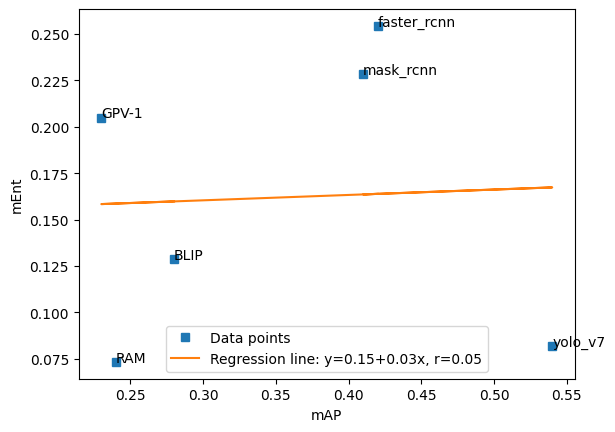

In [364]:
x, y = np.array(list(mF1.values())), np.array(list(mEnt.values()))
print("pearson: ", scipy.stats.pearsonr(x, y))
print("spearman: ", scipy.stats.spearmanr(x, y))
print("kendall: ", scipy.stats.kendalltau(x, y))
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
for i, txt in enumerate(mAP.keys()):
    ax.annotate(txt, (x[i], y[i]))
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('mAP')
ax.set_ylabel('mEnt')
ax.legend(facecolor='white')
# plt.xlim(0.18, 0.7)
# plt.ylim(0.36, 0.55)
plt.show()

In [182]:
import plotly.graph_objects as go

csv_file = "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GPV-1/video-3-segment-2.csv"

df = pd.read_csv(csv_file)

df = gpv_df

fig = go.Figure()

colorscale = [
    [0, color_disagreement],
    [1, color_agreement]
]

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Frames", tickmode='linear'),
    yaxis=dict(title_text="Objects",  tickmode='linear'),
    width=1800,
    height=450,
    margin=dict(l=0, r=0, t=40, b=10),
    title=dict(
        text="",
        font=dict(size=32, color="black"),
        x=0.5,
        y=0.995

    )
)

fig.add_trace(
    go.Heatmap(
        z=df,
        x=[i for i, x in enumerate(list(df.columns))],
        y=[x.capitalize() for i, x in enumerate(list(df.index))],
        colorscale=colorscale,
        zmin=-1,
        zmax=1,
        showscale=False
    )
)

fig.update_layout(
    font_family="Courier New, monospace",
    font_color="black",
    title_font_family="Courier New, monospace",
    title_font_color="black",
    legend_title_font_color="black",
    font=dict(size=26),
)

fig.update_xaxes(ticklabelposition='outside')

fig.update_xaxes(
    tickson="boundaries",
    ticklen=5,
    tickangle=0
)
fig.update_layout(
     xaxis=dict(showgrid=True),
     yaxis=dict(showgrid=True)
)

fig.update_layout(xaxis=dict(domain=[0, 1]))
# fig.update_traces(showscale=False)

# fig.update_layout(legend = dict(orientation = "h",
#                                 x=0,
#                                 y=0.5,
#                                 title_font_family="Sitka Small",
#                                 bgcolor="LightBlue",
#                                 bordercolor="Black",
#                                 borderwidth=2))

# fig.update_traces(width=0.4)

# fig.update_traces(colorbar_orientation='h',
#                   colorbar_tickmode='array',
#                   colorbar_ticktext=["can't predict", '0', '1'],
#                   colorbar_tickvals=[-1, 0, 1],
#                   colorbar_tickangle=0,
#                   selector=dict(type='heatmap')
#                  )

# filename = f'{datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")}.pdf'
filename = 'sub_mod_gpv.pdf'

fig.write_image(
    os.path.join(out_plot_path, filename),
    format='pdf'
)

fig

,Object,Frame-0,Frame-1,Frame-2,Frame-3,Frame-4,Frame-5,Frame-6,Frame-7,Frame-8,Frame-9,Frame-10,Frame-11
0,Accent Paving,1,1,1,1,1,1,1,0,1,1,1,1
1,Barrier Post,0,0,0,1,0,0,0,0,0,1,1,1
2,Barrier Stump,0,0,0,0,0,0,0,0,0,1,1,1
3,Bench,0,0,0,0,0,0,0,0,0,0,0,0
4,Bicycle,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Water Pipes,0,0,0,0,1,0,0,0,1,0,1,1
75,Wet surface,0,1,1,0,1,1,1,1,1,1,1,1
76,Wheelchair,0,0,0,1,0,0,1,0,0,1,0,1
77,White Cane,0,0,0,0,0,1,0,0,1,1,1,0


In [304]:
unq_st_str = []
for x in range(2**8):
    str_bit = str(bin(x)).replace('b', '').zfill(8)
    unq_st_str.append(str_bit)

print(unq_st_str)

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111', '00010000', '00010001', '00010010', '00010011', '00010100', '00010101', '00010110', '00010111', '00011000', '00011001', '00011010', '00011011', '00011100', '00011101', '00011110', '00011111', '00100000', '00100001', '00100010', '00100011', '00100100', '00100101', '00100110', '00100111', '00101000', '00101001', '00101010', '00101011', '00101100', '00101101', '00101110', '00101111', '00110000', '00110001', '00110010', '00110011', '00110100', '00110101', '00110110', '00110111', '00111000', '00111001', '00111010', '00111011', '00111100', '00111101', '00111110', '00111111', '01000000', '01000001', '01000010', '01000011', '01000100', '01000101', '01000110', '01000111', '01001000', '01001001', '01001010', '01001011', '01001100', '01001101', '01001110', '01001111', '01010000', '01010001', '01010010', '01

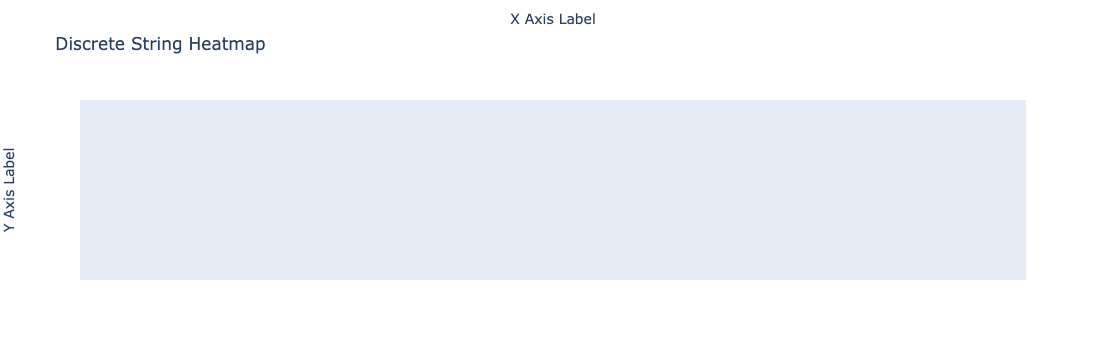

In [124]:
import plotly.graph_objs as go

# Prepare your data
data = [
    ['A', 'B', 'C', 'D'],
    ['E', 'F', 'G', 'H'],
    ['I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P']
]

# Create the go.Heatmap trace
heatmap_trace = go.Heatmap(z=data, x=['Col1', 'Col2', 'Col3', 'Col4'], y=['Row1', 'Row2', 'Row3', 'Row4'])

# Create a layout for the heatmap
layout = go.Layout(
    title='Discrete String Heatmap',
    xaxis=dict(title='X Axis Label'),
    yaxis=dict(title='Y Axis Label')
)

# Create a Figure object
fig = go.Figure(data=[heatmap_trace], layout=layout)

fig

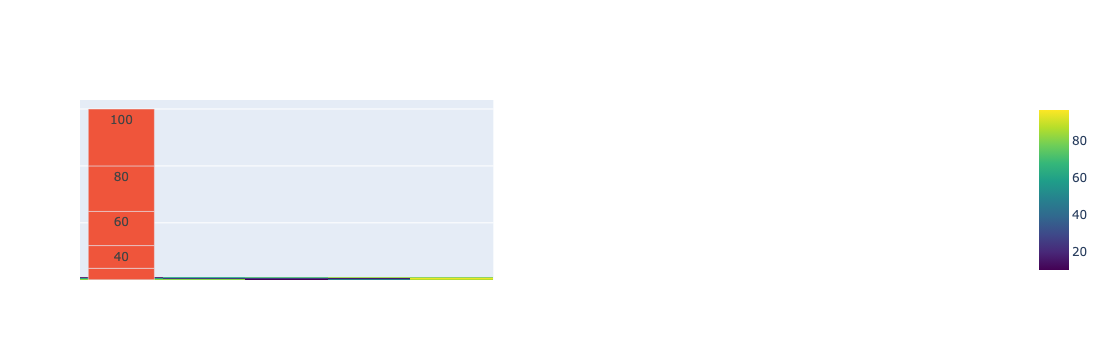

In [142]:
import plotly.graph_objects as go
import numpy as np

# Create heatmap data (random data for this example)
heatmap_data = np.random.randint(0, 100, size=(5, 5))

# Create the heatmap trace
heatmap_trace = go.Heatmap(
    z=heatmap_data,
    colorscale='Viridis',  # Customize the colorscale
)

# Create legend-like data and trace
legend_data = [0, 20, 40, 60, 80, 100]
legend_text = ['0', '20', '40', '60', '80', '100']

legend_trace = go.Bar(
    x=[0] * len(legend_data),
    y=legend_data,
    text=legend_text,
    hoverinfo='text',
    
)

# Create the layout
layout = go.Layout(
    grid={'rows': 1, 'columns': 2, 'pattern': 'independent'},
    xaxis1={'showticklabels': False},
    yaxis1={'showticklabels': False},
    xaxis2={'showticklabels': False},
    yaxis2={'showticklabels': False},
)

# Create the subplot figure and add both the heatmap and legend traces to it
fig = go.Figure(data=[heatmap_trace, legend_trace], layout=layout)

# Show the plot in your Jupyter Notebook or IDE
fig.show()

In [99]:
import pandas as pd

data = [[10, 18, 11], [13, 15, 8], [9, 20, 3]]

df = pd.DataFrame(data)
print(df)
print(list(df.sum()))

    0   1   2
0  10  18  11
1  13  15   8
2   9  20   3
[32, 53, 22]
